### High-concentration water on shelf

Look at HCW calculated as transport of water with tracer concentration higher or equal that threshold across shelf and canyon lid. The threshold is the tracer concentration at shelf break depth.


In [1]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns

import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [2]:
def HCW_Tracer_AlongShelf(Tr,TrNoC,MaskC,rA,hFacC,drF,yin,zfin,xi,yi,nzlim):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mtt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
  TrMaskNoC=np.ma.array(TrNoC,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
  
  HighConc_MaskedNoC = np.ma.masked_less(TrMaskNoC[:,:zfin,yin:,:], trlim) 
  HighConc_MaskNoC = HighConc_MaskedNoC.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  HighConc_CellVolNoC = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_MaskNoC) 
  
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol.data-HighConc_CellVolNoC.data,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc)#, Total_Tracer)

In [3]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('notebook')


In [4]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [5]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [6]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [25]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,f=9.66E-5,L=6400,R=5000.0,Wsb=13000,N=0.0055):
    ''' flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    f2 = (0.9**(1.5))*((Ro(U,f,R))/(1+(Ro(U,f,R)/0.9)))**(1.5)
    f3 = Ro(U,f,L)**(0.5)
    return(f2*f3)

In [8]:
# Save HCW at each 1/2 day into class record.

for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    
    Tr = rout.getField(filename,'Tr2') 
     
    record.HCW = mtt.calc_HCW(Tr, MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, yin=227, xin=0, xfin=359, zfin=30, xi=180, yi=50)
    

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [9]:
# Save HCW at each 1/2 day into class record.

for record in recordsNoC:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    
    record.HCW = mtt.calc_HCW(Tr, MaskCNoC, rA, hFacCNoC, drF[:], nzlim=29, yin=227, xin=0, xfin=359, zfin=30, xi=180, yi=50)
    

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [11]:
# get shelf volume (box sitting over shelf using NoC bathymetry)
ShVol = mtt.calc_ShelfVolume(rA[:,:], hFacCNoC[:,:,:], drF[:], yin=227, zfin=29)
print(ShVol)

253463579347.0


### HCW on shelf

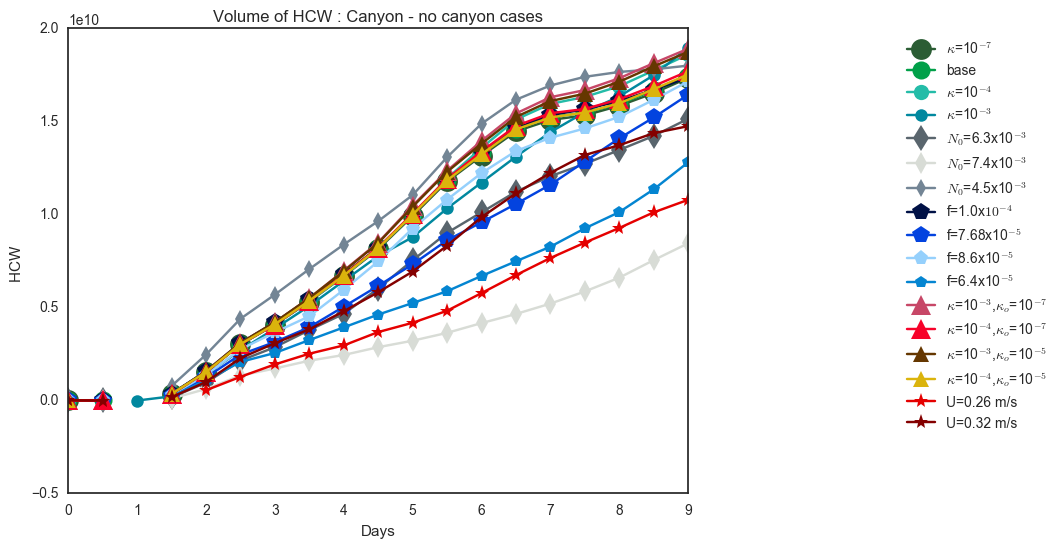

In [12]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    plt1 = ax.plot(time[:]/(3600*24),rec.HCW-recNoC.HCW,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Volume of HCW : Canyon - no canyon cases')
    ax.set_ylabel('HCW ')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



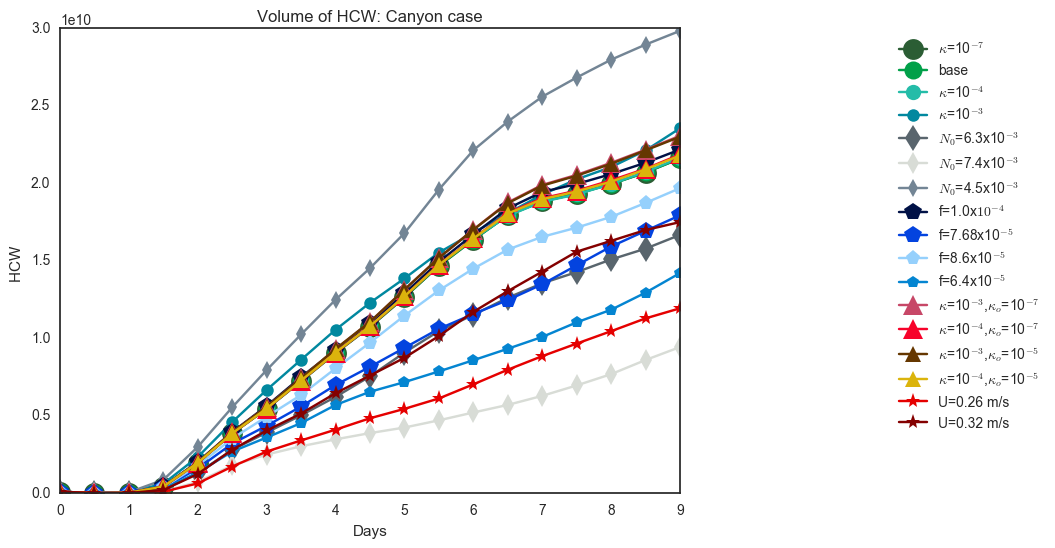

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.plot(time[:]/(3600*24),rec.HCW,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Volume of HCW: Canyon case')
    ax.set_ylabel('HCW ')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



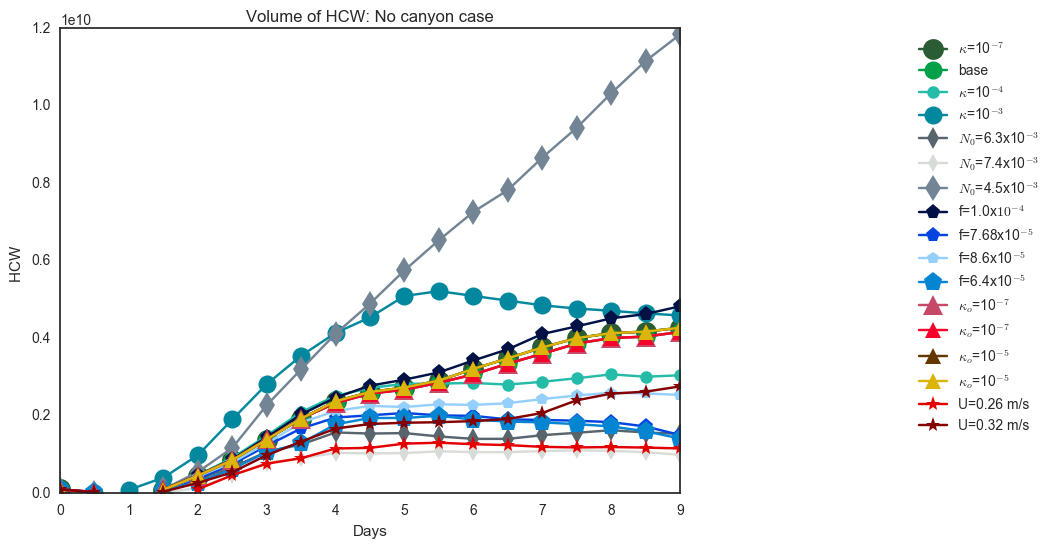

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for recNoC in recordsNoC:
    
    plt1 = ax.plot(time[:]/(3600*24),recNoC.HCW,
                   marker = recNoC.mstyle,
                   markersize = recNoC.msize,
                   color = sns.xkcd_rgb[recNoC.color],
                   label=recNoC.label)
   
    ax.set_title('Volume of HCW: No canyon case')
    ax.set_ylabel('HCW ')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



### Upwelling flux comparison to AH2010 and HA2013

The scaling from Allen and Hickey (2010) estimated the upwelling flux as:

$\frac{\Phi_{AH}}{UW_{sb}D_h} = (\frac{0.9R_o}{1+R_o/0.9})^{3/2}R_L^{1/2} $,

and Howatt and Allen (2013) as:

$\frac{\Phi_{AH}}{UWD_h}= 0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.21S_E)^3+0.07$, 

where 

$S_E=\frac{sN}{f(\mathcal{F}_w/R_L)^{1/2}}$

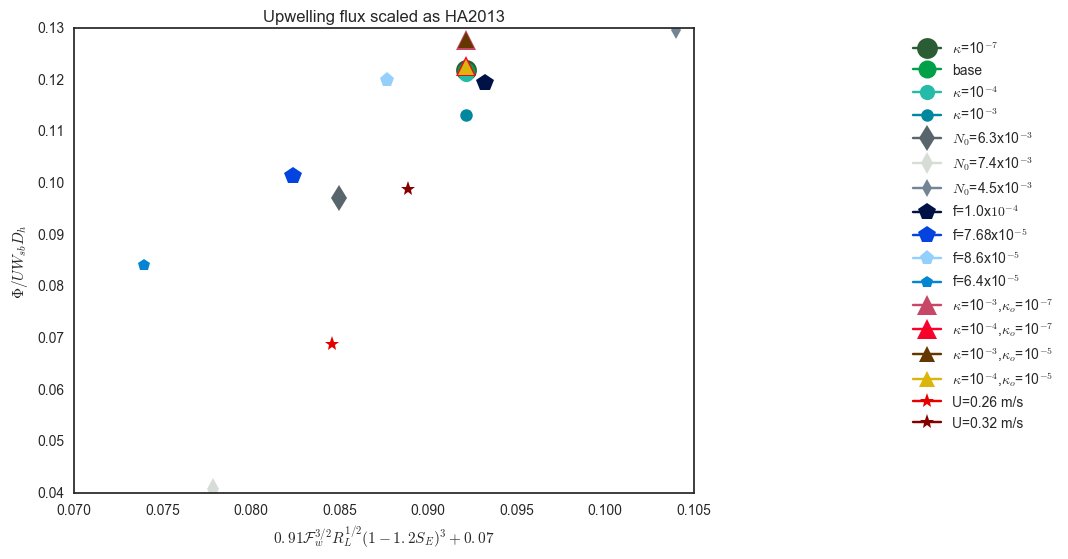

In [21]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07
    
    plt1 = ax.plot(HA2013,
                   (((rec.HCW[12])-(rec.HCW[6]))/(time[12]-time[6]))/(rec.u*W*Dh(rec.f,L,rec.N)),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Upwelling flux scaled as HA2013')
    ax.set_ylabel('$\Phi/UW_{sb}D_h$ ')
    ax.set_xlabel('$0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07$')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



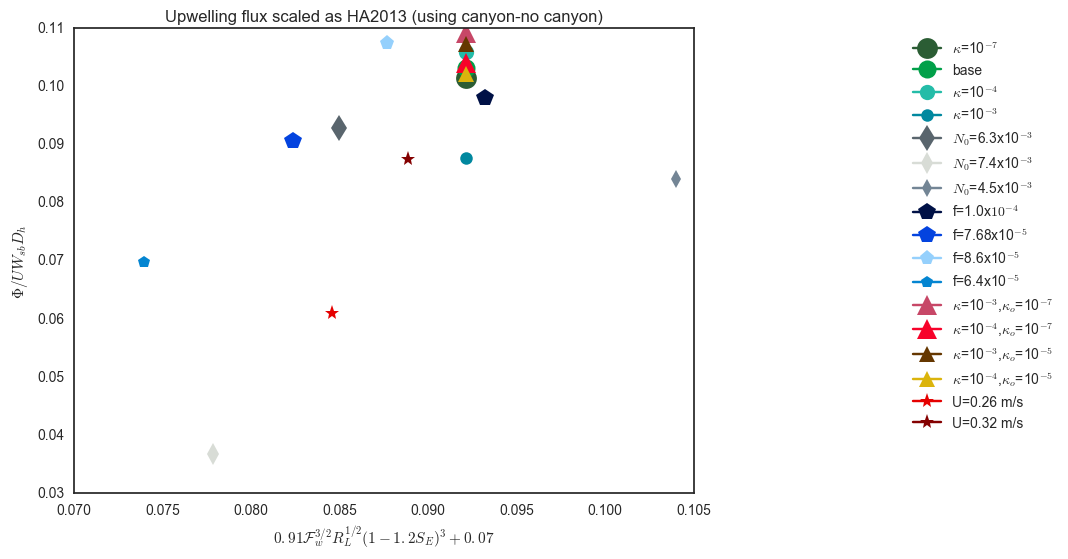

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07
    
    plt1 = ax.plot(HA2013,
                   (((rec.HCW[12]-recNoC.HCW[12])-(rec.HCW[6]-recNoC.HCW[6]))/(time[12]-time[6]))/(rec.u*W*Dh(rec.f,L,rec.N)),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Upwelling flux scaled as HA2013 (using canyon-no canyon)')
    ax.set_ylabel('$\Phi/UW_{sb}D_h$ ')
    ax.set_xlabel('$0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07$')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()



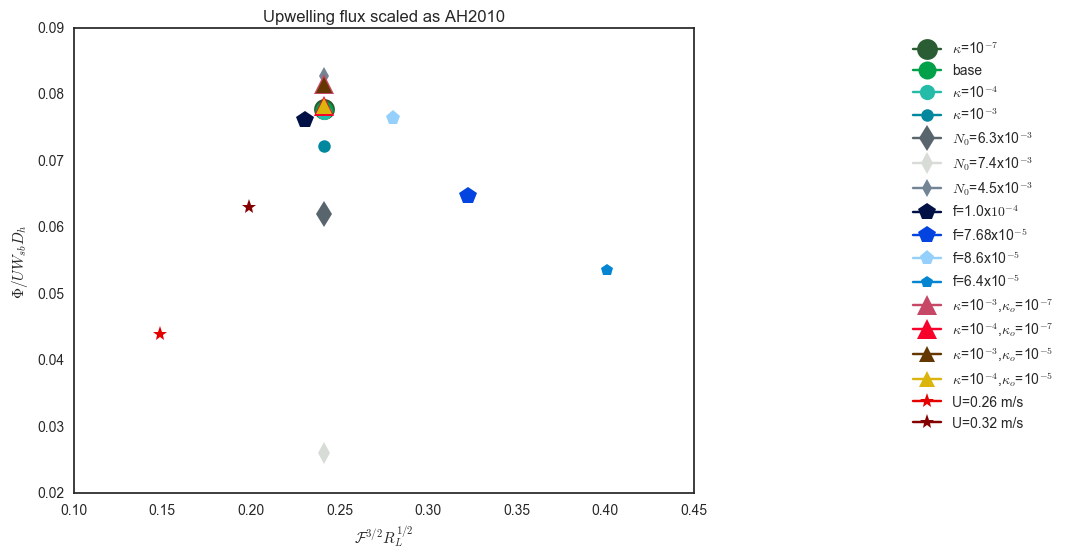

In [28]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    AH2010=(F(Ro(rec.u,rec.f,R))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))
    
    plt1 = ax.plot(AH2010,
                   (((rec.HCW[12])-(rec.HCW[6]))/(time[12]-time[6]))/(rec.u*Wsb*Dh(rec.f,L,rec.N)),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Upwelling flux scaled as AH2010')
    ax.set_ylabel('$\Phi/UW_{sb}D_h$ ')
    ax.set_xlabel('$\mathcal{F}^{3/2}R_L^{1/2}$')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()

